In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

color = sns.color_palette()

# 1. Setting Up

In [3]:
# Import necessary libraries

#misc
import gc
import time
import warnings
import json
import os
import ast

import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

Load the business dataset

In [2]:
business = pd.read_csv('/home/han2114/final_project_tools_analytics/yelp_academic_dataset_business_full.csv')
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 61 columns):
hours.Friday                             141796 non-null object
attributes.RestaurantsAttire             48182 non-null object
attributes.BikeParking                   84891 non-null object
state                                    188593 non-null object
categories                               188052 non-null object
attributes.BusinessParking               103424 non-null object
attributes.Alcohol                       47892 non-null object
attributes.GoodForDancing                9162 non-null object
attributes.BYOB                          911 non-null object
attributes.DietaryRestrictions           138 non-null object
attributes.RestaurantsReservations       51363 non-null object
attributes.GoodForKids                   64931 non-null object
attributes.Smoking                       8113 non-null object
hours.Sunday                             93387 non-null object
attribute

In [4]:
cat_all = ','.join(business['categories'].dropna()).replace(" ", "")
cat_all = pd.DataFrame(cat_all.split(','), columns=['category'])
cat_all_count = cat_all.category.value_counts().sort_values(ascending = False)
print("There are ",len(cat_all_count)," different types/categories of Businesses in Yelp!")

There are  1305  different types/categories of Businesses in Yelp!


In [5]:
cat_all_count

Restaurants                 57173
Shopping                    30231
Food                        27118
Beauty&Spas                 18967
HomeServices                18634
Health&Medical              16157
LocalServices               12906
Automotive                  12656
Nightlife                   12438
Bars                        10853
EventPlanning&Services       9774
ActiveLife                   9119
Fashion                      7406
Coffee&Tea                   6936
Sandwiches                   6912
HairSalons                   6825
FastFood                     6812
American(Traditional)        6659
Pizza                        6603
Home&Garden                  6020
AutoRepair                   5877
Hotels&Travel                5808
Arts&Entertainment           5794
ProfessionalServices         5620
Doctors                      5450
RealEstate                   5295
Burgers                      5126
Breakfast&Brunch             5023
NailSalons                   4839
Fitness&Instru

In [6]:
tfile = open('cat_all_count.txt', 'a')
tfile.write(cat_all_count.to_string())
tfile.close()

In [7]:
food_masks = ['Restaurants', 'Food','Sandwiches', 'FastFood', 'Breakfast&Brunch', 'SpecialtyFood', 'Burgers',
                    'American(Traditional)', 'American(New)','Pizza', 'Italian','African','Falafel','Turkish',
                    'Desserts', 'Bakeries', 'Salad','ChickenWings', 'Mexican','Seafood','Chinese','Malaysian',
                    'IceCream&FrozenYogurt', 'Delis', 'Japanese', 'Bars', 'Canadian(New)', 'AsianFusion',
                    'Mediterranean', 'SushiBars','JuiceBars&Smoothies','Steakhouses','Coffee&Tea','Pretzels','PanAsian',
                    'Barbeque','Beer','Wine&Spirits','SportsBars', 'Pubs','British','Poke','Delicatessen',
                     'Lounges', 'WineBars', 'CocktailBars', 'Diners','Patisserie/CakeShop','Kosher','Afghan',
                     'Vegetarian', 'EthnicFood', 'MiddleEastern','Persian/Iranian','FoodCourt','IrishPub',
                     'Gluten-Free','ComfortFood','Indian','Soup','Vegan', 'Thai','FoodTrucks','Szechuan',
                     'French','Greek','Buffets','Vietnamese','HotDogs','DiveBars','Tex-Mex','HotPot','Polish','Moroccan',
                     'ImportedFood','Gastropubs','Bagels','BeerBar','Halal','Korean','Donuts','Tapas/SmallPlates',
                     'Breweries','Southern','LatinAmerican','Do-It-YourselfFood','InternetCafes','Cantonese',
                     'BubbleTea','TapasBars','Caribbean','Lebanese','CoffeeRoasteries','Gelato','Brazilian',
                     'Pakistani','FoodStands','Hawaiian','Dim Sum','Tacos','SoulFood','Creperies','Ethiopian',
                     'Fish&Chips','Cajun/Creole','Irish','ShavedIce','InternetCafes','Bistros','Peruvian','Waffles',
                     'ModernEuropean','Taiwanese','Filipino','Cheesesteaks','German','Brasseries','Cuban',
                     'Wineries','Ramen','Spanish','Poutineries','TeaRooms','Noodles','Cupcakes','Portuguese']

In [8]:
bus_cats = business['categories']
index_food_masks = list()
NaN_list = list()
for index, bus_cat in enumerate(bus_cats):
    if pd.isnull(bus_cat) == True:
        NaN_list.append(index)
    else:
        if bool(set(bus_cat.replace(" ","").split(',')) & set(food_masks)):
            index_food_masks.append(index)

In [9]:
restaurants = business.iloc[index_food_masks]

In [10]:
cat_all_res = ','.join(restaurants['categories']).replace(" ", "")
cat_all_res = pd.DataFrame(cat_all_res.split(','), columns=['category'])
cat_all_res_count = cat_all_res.category.value_counts().sort_values(ascending = False)
print("There are ",len(cat_all_res_count)," different types/categories of Restaurants in Yelp!")

There are  835  different types/categories of Restaurants in Yelp!


In [11]:
USA_mask = ['AZ','NV','OH','NC','PA','WI','IL','SC','IN','OR','NY','MO','FL','AL','VA','CA']
CAN_mask = ['ON','QC','AB','BC']
UK_mask = ['NYK','XGM','NLK','XMS','CMA','WHT']
GER_mask = ['NI','BY','HE','ST','RP','NW']
location_mask = USA_mask + CAN_mask + UK_mask + GER_mask

In [12]:
index_location_mask = list()
state = restaurants['state']
for index, state in enumerate(state):
    if state in location_mask:
        index_location_mask.append(index)

In [13]:
restaurants = restaurants.iloc[index_location_mask]

In [14]:
def label_country (row):
    if row['state'] in  USA_mask:
          return 'USA'
    if row['state'] in  CAN_mask:
          return 'Canada'
    if row['state'] in  UK_mask:
          return 'UK'
    if row['state'] in  GER_mask:
          return 'Germany'

restaurants['country'] = restaurants.apply(lambda row: label_country(row),axis=1)

# 2. Exploratory Data Analysis

### 2A. Rating Distributions

In [15]:
# Get the distribution of the ratings
rating_dist = restaurants['stars'].value_counts().sort_index()
rating_dist

1.0      540
1.5     1540
2.0     4065
2.5     7400
3.0    12984
3.5    17410
4.0    18145
4.5    10069
5.0     3199
Name: stars, dtype: int64

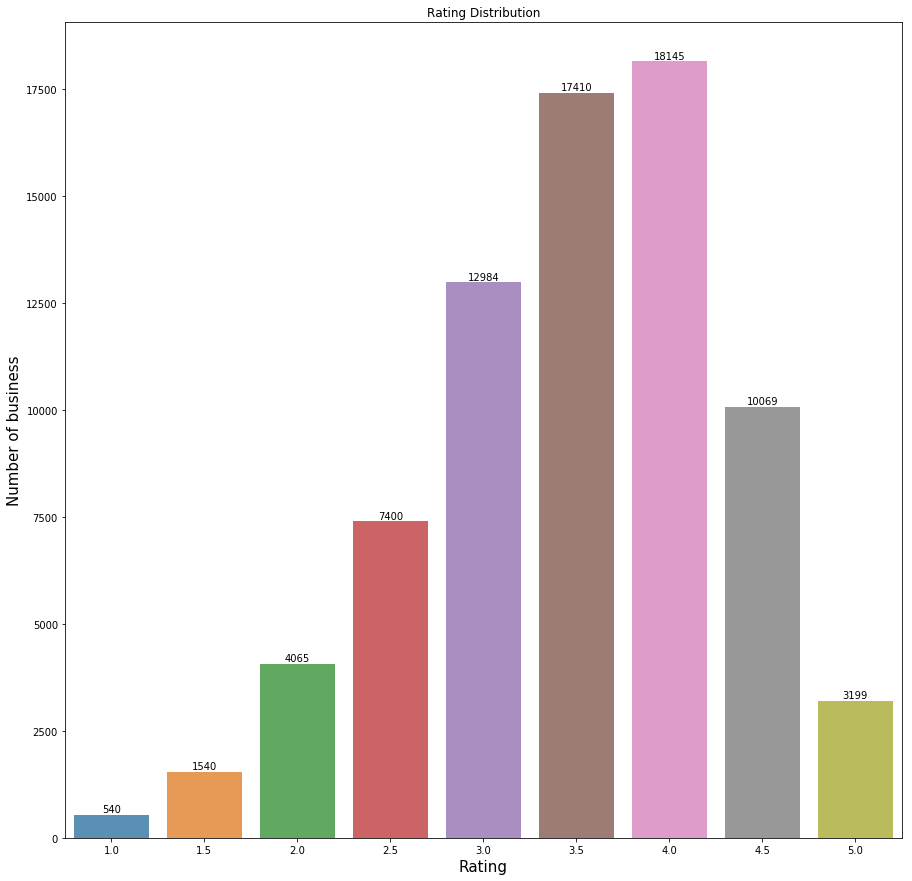

In [16]:
plt.figure(figsize=(15,15))
ax = sns.barplot(rating_dist.index, rating_dist.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Number of business', fontsize=15)
plt.xlabel('Rating', fontsize=15)

rects = ax.patches
labels = rating_dist.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

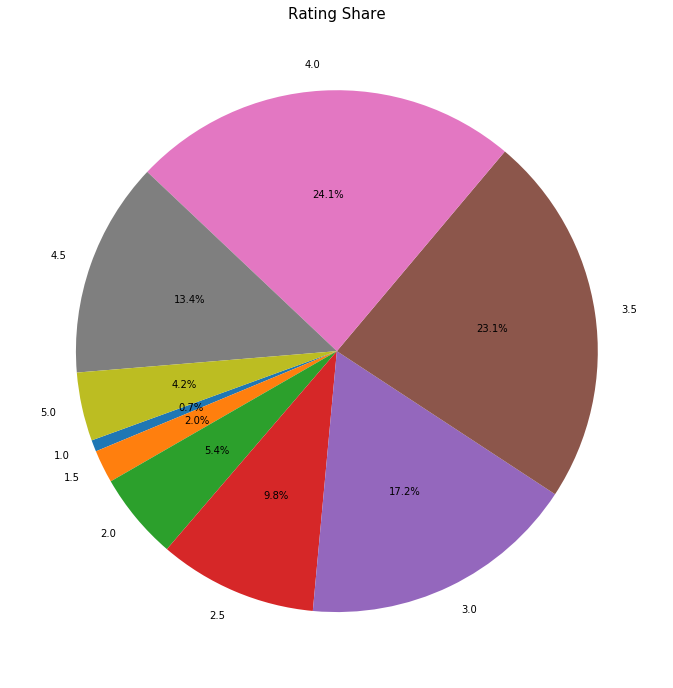

In [17]:
plt.figure(figsize=(12,12))
labels = (np.array(rating_dist.index))
sizes = (np.array((rating_dist / rating_dist.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct= '%1.1f%%', startangle = 200)
plt.title("Rating Share", fontsize=15)
plt.show()

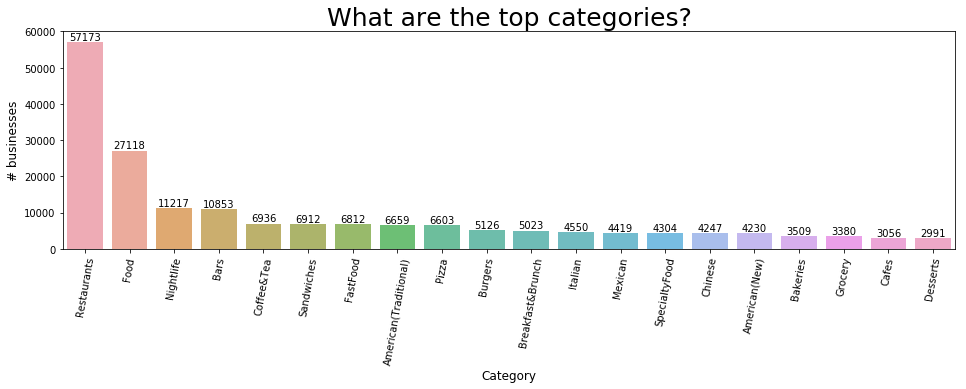

In [18]:
x = cat_all_res_count.iloc[0:20]

plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

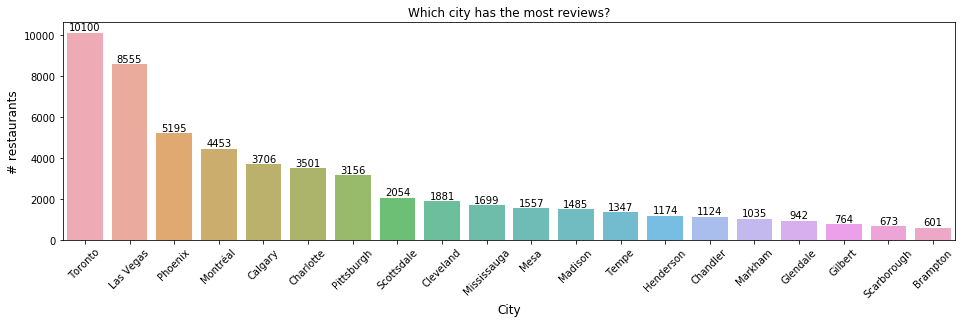

In [19]:
# Location distribution

city_count = restaurants['city'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(city_count[0:20].index, city_count[0:20].values, alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('City', fontsize=12)

rects = ax.patches
labels = city_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

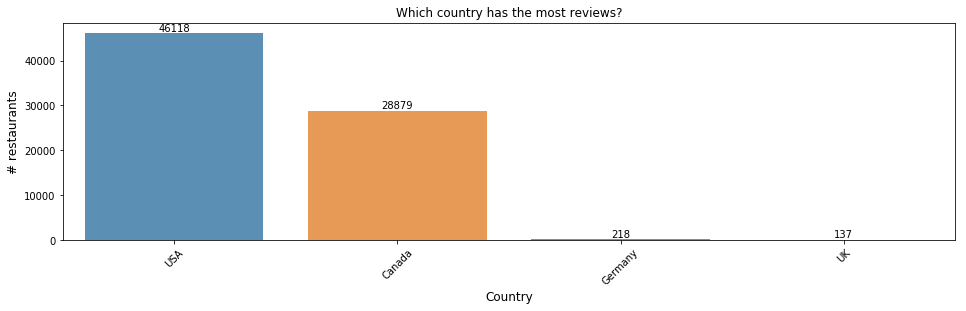

In [20]:
# Country distribution

country_count = restaurants['country'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title("Which country has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('Country', fontsize=12)

rects = ax.patches
labels = country_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [21]:
# Top restaurants by number of reviews

top_res = restaurants[restaurants['stars'] == 5.0]
top_res.loc[top_res['review_count'].idxmax()]['review_count']

1746

# 3. Feature Selection

## 3.0 We hypothesize that the following features are important

Review and User-related features

1. Review Count
2. Star Rating
3. Number of users who wrote reviews
4. Maximum number of stars
5. Minimum number of stars
6. Number of reviews voted as 'cool'
7. Number of reviews voted as 'funny'
8. Number of reviews voted as 'useful'
9. Time since first/last reviews
10. Time between first and last reviews
11. Max number of review in a single day


Business Attributes Feature:
    
1. Hours
2. Categories
3. Business Parking
4. Restaurant Reservations
5. Good for Kids
6. Smoking
7. Good for Meal
8. Noise Level
9. Music
10. Ages Allowed
11. Restaurants Good for Groups
12. WiFi
13. Business Accepts Credit Cards
14. Ambience
15. Restaurant Price Range
16. Happy Hour
17. Outdoors Seating

In [34]:
col

Index(['hours.Friday', 'attributes.RestaurantsAttire',
       'attributes.BikeParking', 'state', 'categories',
       'attributes.BusinessParking', 'attributes.Alcohol',
       'attributes.GoodForDancing', 'attributes.BYOB',
       'attributes.DietaryRestrictions', 'attributes.RestaurantsReservations',
       'attributes.GoodForKids', 'attributes.Smoking', 'hours.Sunday',
       'attributes.BYOBCorkage', 'latitude',
       'attributes.BusinessAcceptsBitcoin', 'attributes.GoodForMeal',
       'attributes.BestNights', 'attributes.NoiseLevel', 'attributes.Corkage',
       'attributes.Music', 'hours.Wednesday', 'attributes.Open24Hours',
       'longitude', 'neighborhood', 'attributes.HairSpecializesIn',
       'hours.Thursday', 'attributes.AgesAllowed',
       'attributes.ByAppointmentOnly', 'business_id',
       'attributes.RestaurantsDelivery', 'attributes.RestaurantsGoodForGroups',
       'postal_code', 'attributes.RestaurantsTableService', 'attributes.WiFi',
       'hours', 'attributes

## 3.1 Merge Restaurants with Users and Reviews

In [35]:
#importing the yelp reviews dataset
datastr=open('yelp_academic_dataset_review.json','r')
datajson=datastr.readlines()
check=[json.loads(x) for x in datajson]
ind=range(0,len(check))
reviews=pd.DataFrame(check,index=ind,columns=check[0].keys())

In [43]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')

In [44]:
restaurant_reviews = reviews[reviews["business_id"].isin(restaurants["business_id"])]

In [100]:
# User counts, max and min ratings
user_rating_count = restaurant_reviews[['user_id','business_id']].groupby(['business_id']).count()
user_rating_count = user_rating_count.rename(columns = {'business_id':'user_rating_count'})
max_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).max()
max_rating_restaurant = max_rating_restaurant.rename(columns = {'stars':'max_rating_rest'})
min_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).min()
min_rating_restaurant = min_rating_restaurant.rename(columns = {'stars':'min_rating_rest'})

In [74]:
# Useful, funny, cool
useful_mean = restaurant_reviews[['business_id','useful']].groupby(['business_id']).mean()
useful_mean = useful_mean.rename(columns = {'business_id':'useful_mean'})
funny_mean = restaurant_reviews[['business_id','funny']].groupby(['business_id']).mean()
funny_mean = funny_mean.rename(columns = {'business_id':'funny_mean'})
cool_mean = restaurant_reviews[['business_id','cool']].groupby(['business_id']).mean()
cool_mean = cool_mean.rename(columns = {'business_id':'cool_mean'})

In [101]:
restaurants = restaurants.merge(user_rating_count, how = 'left', on = 'business_id')

In [105]:
user_rating_count = restaurant_reviews[['user_id','business_id']]

In [104]:
user_rating_count = 

## 3.2 Ambience

In [108]:
# Understand the ambience
restaurants['attributes.Ambience'].unique()

array([nan,
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': True, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",
       "{'roma

In [110]:
def ambience_extract(row):
    ambience_list = list()
    import ast
    if pd.isnull(row['attributes.Ambience']):
        return None
    else:
        for key, value in ast.literal_eval(row['attributes.Ambience']).items():
            if value == True:
                ambience_list.append(key)
        return ",".join(ambience_list)

In [111]:
restaurants['Ambience'] = restaurants.apply(lambda row: ambience_extract(row),axis=1)

In [112]:
ambience_list = restaurants['Ambience'].tolist()
ambience_list = [x for x in ambience_list if x is not None and x != '']

In [113]:
cat_all_am = ','.join(ambience_list)

In [114]:
cat_all_am = pd.DataFrame(cat_all_am.split(','), columns=['Ambience'])
cat_all_am_count = cat_all_am.Ambience.value_counts().sort_values(ascending = False)
cat_all_am_count

casual      22191
trendy       2428
classy       1061
divey        1057
hipster      1043
intimate      672
romantic      600
upscale       494
touristy      228
Name: Ambience, dtype: int64

We create dummy variables for 'casual', 'trendy' and 'Others'

In [120]:
def ambience_casual(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'casual' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_casual'] = restaurants.apply(lambda row: ambience_casual(row),axis=1)

In [123]:
def ambience_trendy(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'trendy' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_trendy'] = restaurants.apply(lambda row: ambience_trendy(row),axis=1)

In [125]:
ambience_others_list = ['romantic', 'intimate', 'classy', 'hipster', 'touristy', 'upscale', 'divey']
def ambience_others(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if (set(ambience_others_list) & set(row['Ambience'].split(','))):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_others'] = restaurants.apply(lambda row: ambience_others(row),axis=1)

## 3.3 Food categories

In [91]:
cat_all_res_count

Restaurants                    57173
Food                           27118
Nightlife                      11217
Bars                           10853
Coffee&Tea                      6936
Sandwiches                      6912
FastFood                        6812
American(Traditional)           6659
Pizza                           6603
Burgers                         5126
Breakfast&Brunch                5023
Italian                         4550
Mexican                         4419
SpecialtyFood                   4304
Chinese                         4247
American(New)                   4230
Bakeries                        3509
Grocery                         3380
Cafes                           3056
Desserts                        2991
EventPlanning&Services          2929
Shopping                        2735
IceCream&FrozenYogurt           2613
Japanese                        2566
ChickenWings                    2538
Seafood                         2369
Salad                           2350
S

## 3.4 Create Dummy Variables for features

In [129]:
cols_dummy = ['attributes.RestaurantsAttire','attributes.Alcohol',
        'attributes.RestaurantsReservations','attributes.GoodForKids','attributes.Smoking',
        'attributes.NoiseLevel','attributes.Open24Hours',
        'attributes.AgesAllowed','attributes.ByAppointmentOnly','attributes.RestaurantsDelivery',
        'attributes.RestaurantsGoodForGroups','attributes.RestaurantsTableService','attributes.WiFi',
        'attributes.DogsAllowed','attributes.BusinessAcceptsCreditCards',
        'attributes.DriveThru','attributes.Caters','attributes.RestaurantsPriceRange2','attributes.RestaurantsTakeOut',
        'attributes.WheelchairAccessible','attributes.HasTV','attributes.HappyHour',
        'attributes.CoatCheck','attributes.OutdoorSeating','is_open','attributes.AcceptsInsurance']
        
        
special_col = ['attributes.GoodForMeal', 'attributes.BestNights','attributes.Music',
               'hours', 'attributes.BusinessParking','attributes.RestaurantsAttire']

In [130]:
res_full = pd.get_dummies(data=restaurants, columns = cols_dummy)

In [131]:
res_full.columns.values.tolist()

['hours.Friday',
 'attributes.BikeParking',
 'state',
 'categories',
 'attributes.BusinessParking',
 'attributes.GoodForDancing',
 'attributes.BYOB',
 'attributes.DietaryRestrictions',
 'hours.Sunday',
 'attributes.BYOBCorkage',
 'latitude',
 'attributes.BusinessAcceptsBitcoin',
 'attributes.GoodForMeal',
 'attributes.BestNights',
 'attributes.Corkage',
 'attributes.Music',
 'hours.Wednesday',
 'longitude',
 'neighborhood',
 'attributes.HairSpecializesIn',
 'hours.Thursday',
 'business_id',
 'postal_code',
 'hours',
 'review_count',
 'name',
 'hours.Saturday',
 'attributes.Ambience',
 'attributes.RestaurantsCounterService',
 'address',
 'hours.Tuesday',
 'hours.Monday',
 'attributes',
 'stars',
 'city',
 'country',
 'Ambience',
 'user_id',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others',
 'attributes.RestaurantsAttire_casual',
 'attributes.RestaurantsAttire_dressy',
 'attributes.RestaurantsAttire_formal',
 'attributes.Alcohol_beer_and_wine',
 'attributes.Alcohol_full_bar',
 

## 3.10 Final Feature Selection

In [132]:
cols_ml = ['review_count',
 'attributes.RestaurantsAttire_casual',
 'attributes.RestaurantsAttire_dressy',
 'attributes.RestaurantsAttire_formal',
 'attributes.Alcohol_full_bar',
 'attributes.RestaurantsReservations_True',
 'attributes.GoodForKids_True',
 'attributes.Smoking_outdoor',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.AgesAllowed_21plus',
 'attributes.ByAppointmentOnly_True',
 'attributes.RestaurantsGoodForGroups_True',
 'attributes.WiFi_free',
 'attributes.DogsAllowed_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.DriveThru_True',
 'attributes.Caters_True',
 'attributes.RestaurantsPriceRange2_1.0',
 'attributes.RestaurantsPriceRange2_2.0',
 'attributes.RestaurantsPriceRange2_3.0',
 'attributes.RestaurantsPriceRange2_4.0',
 'attributes.RestaurantsTakeOut_True',
 'attributes.HappyHour_True',
 'attributes.CoatCheck_True',
 'attributes.OutdoorSeating_True',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others']

# 4. Machine Learning Models

* Logistic Regression
* Random Forest
* Bootstrapping
* XGBoost

## 4.1 Simple Linear Regression

In [134]:
X = res_full[cols_ml]
y = restaurants['stars']

In [135]:
X.fillna(0,inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [136]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score

In [139]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 11)

In [140]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [141]:
pred_y  = model.predict(test_X)
pred_y

array([3.63023415, 3.65579102, 3.44407855, ..., 3.12964321, 4.05438404,
       3.46762429])

In [142]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, pred_y))

Coefficients: 
 [ 3.74415041e-04 -2.56492679e-01 -5.06435803e-02 -1.95949836e-01
 -1.41491063e-01  1.03214997e-01 -2.66644756e-02 -6.81815030e-02
  6.01992942e-02 -3.73939745e-01 -2.41812524e-01 -2.09430983e-01
  4.73690473e-01  9.27250637e-03  2.83668552e-02  2.95046105e-01
 -1.30378618e-01 -8.56012841e-01  1.47302805e-01  2.57706115e-01
  2.04280105e-01  2.13593457e-01  1.80953826e-01  5.18877455e-03
 -1.65356526e-02 -7.42674938e-02  4.87487428e-02  1.38169639e-01
  2.07599293e-01  2.44538044e-01]
Mean squared error: 0.61
Variance score: 0.11


## 4.1.1 Try to classify the successful restaurant using the result above

In [143]:
res_full['success'] = np.where(restaurants['stars'] >= 3.5,1,0)

In [145]:
X = res_full[cols_ml]
y = res_full['success']
X.fillna(0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 11)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [146]:
def get_classification(predictions, threshold):
    classes = np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = 1
    return classes
get_classification(pred_y, 4)

array([0., 0., 0., ..., 0., 1., 0.])

In [147]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_y, get_classification(pred_y,4)).ravel()
print(tn, fp, fn, tp)

7952 26 14245 383


In [148]:
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(accuracy)

0.36870742280810404


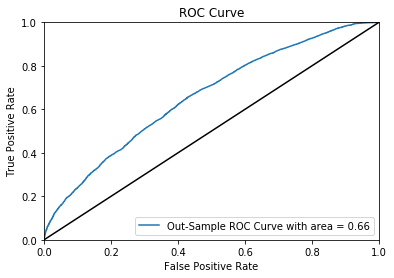

In [151]:
from sklearn.metrics import roc_curve, auc
testing_predictions = model.predict(test_X)
(fpr, tpr, thresholds) = roc_curve(test_y,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 4.2 Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression().fit(train_X,train_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [153]:
trainset_acc = logr.score(train_X,train_y)
print('logr training set accuracy: {:.3f}'.format(trainset_acc))

logr training set accuracy: 0.673


In [155]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(train_X, train_y)
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[False  True False  True  True  True False False False  True  True  True
  True False False  True  True  True  True  True  True  True  True False
 False  True False  True  True  True]
[11  1  2  1  1  1  6  3  7  1  1  1  1 10  5  1  1  1  1  1  1  1  1  8
  9  1  4  1  1  1]


In [164]:
cols_log = ['attributes.RestaurantsAttire_casual',
 'attributes.RestaurantsAttire_formal',
 'attributes.Alcohol_full_bar',
 'attributes.RestaurantsReservations_True',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.AgesAllowed_21plus',
 'attributes.ByAppointmentOnly_True',
 'attributes.DogsAllowed_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.DriveThru_True',
 'attributes.Caters_True',
 'attributes.RestaurantsPriceRange2_1.0',
 'attributes.RestaurantsPriceRange2_2.0',
 'attributes.RestaurantsPriceRange2_3.0',
 'attributes.RestaurantsPriceRange2_4.0',
 'attributes.CoatCheck_True',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others']

In [165]:
X = X[cols_log]

In [168]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.609372
         Iterations 6
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.061     
Dependent Variable:           success                  AIC:                      91874.7453
Date:                         2018-12-01 08:19         BIC:                      92059.3438
No. Observations:             75352                    Log-Likelihood:           -45917.   
Df Model:                     19                       LL-Null:                  -48882.   
Df Residuals:                 75332                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               6.0000                                                       
-------------------------------------------------------------------------------------------
                 

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [170]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67


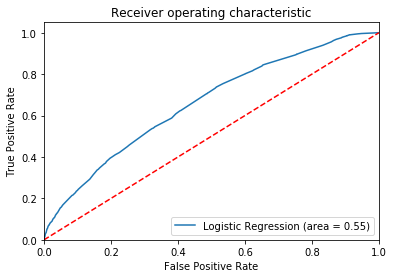

In [171]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 4.3 Random Forest

In [172]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model.fit(train_X, np.ravel(train_y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
model.score(test_X,test_y)

0.6348314606741573

Text(0.5, 0, 'Relative Importance')

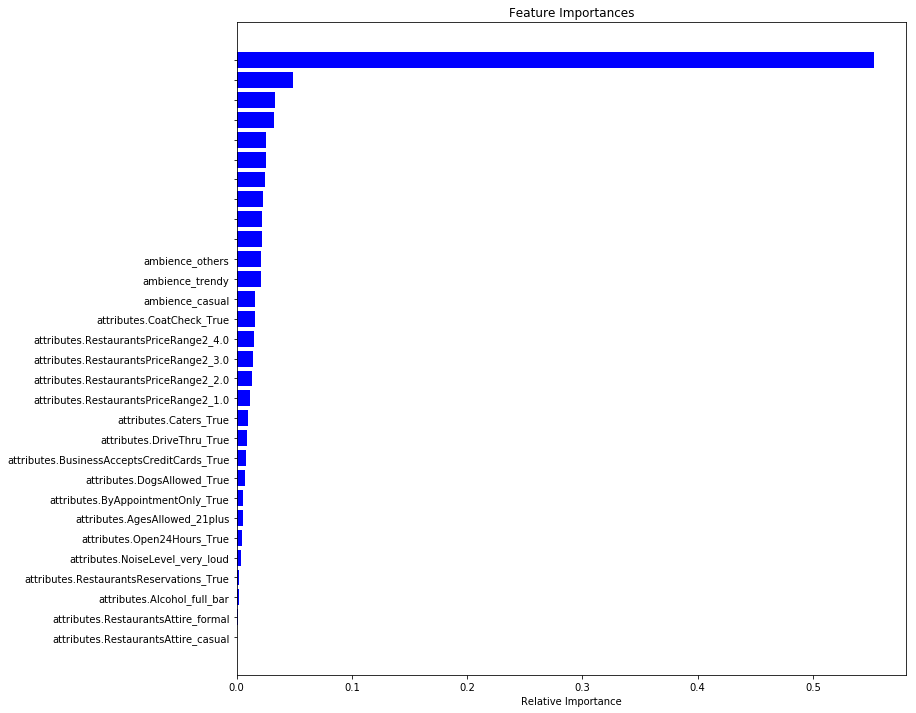

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), cols_ml)
plt.xlabel('Relative Importance')

## 4.4 Bootstrapping

In [177]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier()
model.fit(train_X,np.ravel(train_y))

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [178]:
model.score(test_X,test_y)

0.6327081305848005

## 4.5 XGBoost

In [181]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.95)

In [182]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest= xgb.DMatrix(X_test,label=y_test)

In [183]:
train_labels = dtrain.get_label()

params = { 'eta':0.3, 'silent':1, 'objective':'binary:logistic' }
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [185]:
import random
for i in range(10):
    mcw=random.randint(1,5)
    gamma=random.randrange(1,5,step=1)/2
    subsample=random.randrange(6,11,step=1)/10
    colbt=random.randrange(6,11,step=1)/10
    maxdepth=random.randint(2,5)

    params[ 'min_child_weight']=mcw
    params['gamma']=gamma
    params['subsample']=subsample
    params[ 'colsample_bytree']=colbt
    params['max_depth']=maxdepth

    num_rounds = 50
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    print(params,'\n')
    bst = xgb.train(params, dtrain, num_rounds, watchlist)
    print('+++++++++++++++++++++++++++++++++++++++++++++++\n')

{'eta': 0.3, 'silent': 1, 'objective': 'binary:logistic', 'scale_pos_weight': 0.5444854448544485, 'min_child_weight': 5, 'gamma': 1.5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'max_depth': 3} 

[0]	test-error:0.382901	train-error:0.370852
[1]	test-error:0.382901	train-error:0.370852
[2]	test-error:0.379381	train-error:0.367401
[3]	test-error:0.372341	train-error:0.362092
[4]	test-error:0.372187	train-error:0.361295
[5]	test-error:0.420745	train-error:0.408813
[6]	test-error:0.372592	train-error:0.361561
[7]	test-error:0.403241	train-error:0.390496
[8]	test-error:0.403269	train-error:0.390762
[9]	test-error:0.425131	train-error:0.417043
[10]	test-error:0.424768	train-error:0.417839
[11]	test-error:0.401523	train-error:0.388904
[12]	test-error:0.426961	train-error:0.411733
[13]	test-error:0.415352	train-error:0.404035
[14]	test-error:0.409569	train-error:0.396602
[15]	test-error:0.408521	train-error:0.395806
[16]	test-error:0.409555	train-error:0.396868
[17]	test-error:0.409681	train-e

In [187]:
import xgboost as xgb
preds = bst.predict(dtest)

In [188]:
res=[ i>0.5 for i in preds]
res=np.array(res).astype(np.int8)
from sklearn.metrics import roc_auc_score
result=roc_auc_score(np.squeeze(y_test).values,res)
result

0.6059575861744565